author : Aydin Abiar

NYU netID : aa9380

NYU N number : N16335205

Final project of the *CSCI-GA 3033-091*  Introduction to Deep Learning Systems


# Introduction and Description

In this project, we study the relationship between image compression in the dataset and the network performance.
The dataset chosen is CIFAR-10 and the network is a CNN that already achieve ~90% on the raw CIFAR-10 from keras.

We predict a degradation of the performance of the network the more we compress the image. The question is how ?

The network used come from this blog 
https://appliedmachinelearning.blog/2018/03/24/achieving-90-accuracy-in-object-recognition-task-on-cifar-10-dataset-with-keras-convolutional-neural-networks/

With this repo
https://github.com/abhijeet3922/Object-recognition-CIFAR-10/blob/master/cifar10_90.py

# Imports

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
from keras.models import Sequential
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.datasets import cifar10
from keras import regularizers
from keras.callbacks import LearningRateScheduler
import numpy as np
import io
import time
import numpy as np
from PIL import Image
import nvidia_smi


# Introduction Code

## Load CIFAR-10 Data 

In [2]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')


num_classes = 10
y_train = np_utils.to_categorical(y_train,num_classes)
y_test = np_utils.to_categorical(y_test,num_classes)


170508288/170498071 [==============================] - 13s 0us/step


## Lossy vs Lossless compression

Compression algorithm can be divided in 2 categories : lossy and lossless algorithm. 

Lossless algorithms compress data using the redundancy for example. Therefore, it is possible to decode a compressed image without losing any of its previous information. Such methods are prefered if the quality of the image is important but they are less effective if we want to lower the images size.

Lossy algorithms compress data using approximation methods (WaveLets for JPG for example) which output new images with lower information than the original image. Therefore, decoding the compressed image results in a lower quality image where it can be more difficult to perceive what is the object represented. Those algorithms such as JPG allow tremendous compression rate and the quality maintained during the compression be manually tuned.

## Model

This model will be used for the experiments.
We choose this architecure because it achieves a 75% validation accuracy in 40 minutes only (TTA)

In [3]:
def create_model(print_model= True) :
    model = Sequential()
    model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), input_shape=x_train.shape[1:]))
    model.add(Activation('elu'))
    model.add(BatchNormalization())
    model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation('elu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation('elu'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation('elu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.3))

    model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation('elu'))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation('elu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.4))

    model.add(Flatten())
    model.add(Dense(num_classes, activation='softmax'))

    if print_model :
        model.summary()
    return model

## Training Hyperparameters

Here are the Training hyperparameters and functions (callbacks) used for the training. We keep these hyperparameters constant because we are only interested in varying the compression algorithms

In [4]:
#z-score to normalize the data
def z_score(x_train, x_test):
  x_train = x_train.astype('float32')
  x_test = x_test.astype('float32')
  mean = np.mean(x_train,axis=(0,1,2,3))
  std = np.std(x_train,axis=(0,1,2,3))
  x_train = (x_train-mean)/(std+1e-7)
  x_test = (x_test-mean)/(std+1e-7)

In [5]:
# Learning Rate Scheduler 
def lr_schedule(epoch):
    lrate = 0.001
    if epoch > 75:
        lrate = 0.0005
    if epoch > 100:
        lrate = 0.0003        
    return lrate

# TTA Callback + Hardware utilization
TTA_time = None
#nvidia_smi.nvmlInit()
#handle = nvidia_smi.nvmlDeviceGetHandleByIndex(0) # Handle for gpu/mem utlization
gpu_util = {
    'vanilla' : [], # No compression
    'jpeg' : [], # Lossy
    'png' : [] # Lossless
}
mem_util = {
    'vanilla' : [], # No compression
    'jpeg' : [], # Lossy
    'png' : [] # Lossless
}
class MonitorCallback(tf.keras.callbacks.Callback):
    def __init__(self, val_acc_threshold, experiment):
        super(MonitorCallback, self).__init__()
        self.val_acc_threshold = val_acc_threshold
        self.experiment = experiment

    def on_epoch_end(self, epoch, logs=None): 
        #res = nvidia_smi.nvmlDeviceGetUtilizationRates(handle)
        #gpu_util[self.experiment].append(res.gpu)
        #mem_util[self.experiment].append(res.memory)
        print(f'gpu: {res.gpu}%, gpu-mem: {res.memory}%')
        val_acc = logs["val_accuracy"]
        if val_acc >= self.val_acc_threshold:
            TTA_time = time.time()
            self.model.stop_training = True

In [6]:
val_acc_threshold = 0.75
weight_decay = 1e-4
batch_size = 64
EPOCHS = 2

## Data Augmentation

In [7]:
#data augmentation generator
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    )

## Vanilla Training

here we train the model on the original CIFAR-10 dataset

In [9]:
model = create_model()

#training
opt_rms = keras.optimizers.RMSprop(learning_rate=0.001,decay=1e-6)
datagen.fit(x_train)
model.compile(loss='categorical_crossentropy', optimizer=opt_rms, metrics=['accuracy'])
history = model.fit(datagen.flow(x_train, y_train, batch_size=batch_size),\
                    steps_per_epoch=x_train.shape[0] // batch_size,epochs= EPOCHS,\
                    verbose=1,validation_data=(x_test,y_test),callbacks=[LearningRateScheduler(lr_schedule), MonitorCallback(val_acc_threshold, 'vanilla')])

#save to disk
model_json = model.to_json()
with open('model.json', 'w') as json_file:
    json_file.write(model_json)

model.save_weights('model.h5') 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 activation (Activation)     (None, 32, 32, 32)        0         
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 32, 32, 32)        0         
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                        

KeyboardInterrupt: ignored

# First experiment : JPEG lossy Compression

In this experiment, we will compress the CIFAR-10 dataset using the JPEG algorithm with different qualities and compare the evolution of different metrics such as : TTA (75% validation accuracy), GPU utilization, memory utilization, total dataset size in Mb

Let's see if this "loss" can be useless to the human eye but harmful to the network training

## Compress data

Let's compress the training data 1,2, ..., N times using the JPEG compression method with N different qualities. It is important to not compress the test data as it should be a benchmark for every runs

In [8]:
def compress_JPEG(x_train, quality) :
    N_DATA = len(x_train)
    print('Compressing ...')
    output = io.BytesIO() # Create BytesIO object
    # Load all training images and write into BytesIO object
    for numpy_img in x_train:
        im = Image.fromarray(numpy_img)
        im.save(output, format='JPEG', quality= quality)
    print('Done compressing')

    nbytes_dataset = output.getbuffer().nbytes # Size of compressed dataset in bytes

    # Read back images from BytesIO ito list
    print('Reading image from buffer...')
    compressed_dataset = [np.array(Image.open(output)) for _ in range(N_DATA)]
    print('Done reading')
    
    return np.array(compressed_dataset), nbytes_dataset

In [9]:
QUALITIES = [95,90,80,70,50,30,20,10] # JPEG quality parameters

nbytes_datasets = [] # byte size of dataset after each compression compression
compressed_datasets = [] # the N training datasets

x_train_ = x_train.astype('uint8')
for i, quality in enumerate(QUALITIES) :
  print(f'Iteration n°{i+1}')
  compr_dts, nbytes_dts = compress_JPEG(x_train_, quality)
  compressed_datasets.append(compr_dts.astype('float32'))
  nbytes_datasets.append(nbytes_dts)

Iteration n°1
Compressing ...
Done compressing
Reading image from buffer...
Done reading
Iteration n°2
Compressing ...
Done compressing
Reading image from buffer...
Done reading
Iteration n°3
Compressing ...
Done compressing
Reading image from buffer...
Done reading
Iteration n°4
Compressing ...
Done compressing
Reading image from buffer...
Done reading
Iteration n°5
Compressing ...
Done compressing
Reading image from buffer...
Done reading
Iteration n°6
Compressing ...
Done compressing
Reading image from buffer...
Done reading
Iteration n°7
Compressing ...
Done compressing
Reading image from buffer...
Done reading
Iteration n°8
Compressing ...
Done compressing
Reading image from buffer...
Done reading


Let's plot the dataset size decrease thanks to the compressions

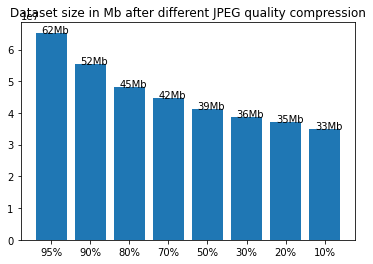

In [10]:
plt.figure()
plt.bar([str(q) + '%' for q in QUALITIES], nbytes_datasets)
plt.title('Dataset size in Mb after different JPEG quality compression')
xlocs, _ = plt.xticks()
for i, v in enumerate(nbytes_datasets):
    plt.text(xlocs[i] - 0.25, v + 0.01, str(v//2**20) + 'Mb')

We can see that a 10% JPEG quality will compress the dataset up to 50% its original size 

Let's compare the original dataset and the compressed ones 

Label = frog


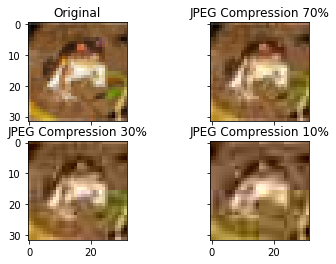

In [11]:
print(f"Label = {classes[np.argmax(y_train[0])]}")
fig, axs = plt.subplots(2,2)
axs[0, 0].imshow(x_train.astype('uint8')[0])
axs[0, 0].set_title('Original')

axs[0, 1].imshow(compressed_datasets[3].astype('uint8')[0])
axs[0, 1].set_title('JPEG Compression 70%')

axs[1, 0].imshow(compressed_datasets[5].astype('uint8')[0])
axs[1, 0].set_title('JPEG Compression 30%')

axs[1, 1].imshow(compressed_datasets[7].astype('uint8')[0])
axs[1, 1].set_title('JPEG Compression 10%')

for ax in axs.flat:
    ax.label_outer()

## Training

Now we train on each compressed dataset

In [15]:
for i, train_set in enumerate(compressed_datasets) :
  print(f'Training for JPEG Compression of quality {QUALITIES[i]}%')
  #data augmentation generator
  datagen = ImageDataGenerator(
      rotation_range=15,
      width_shift_range=0.1,
      height_shift_range=0.1,
      horizontal_flip=True,
      )
  model = create_model(print_model= False)
  #training
  opt_rms = keras.optimizers.RMSprop(learning_rate=0.001,decay=1e-6)
  z_score(train_set, x_train)
  datagen.fit(train_set)
  model.compile(loss='categorical_crossentropy', optimizer=opt_rms, metrics=['accuracy'])
  history = model.fit(datagen.flow(train_set, y_train, batch_size=batch_size),\
                      steps_per_epoch=train_set.shape[0] // batch_size,epochs= EPOCHS,\
                      verbose=1,validation_data=(x_test,y_test),callbacks=[LearningRateScheduler(lr_schedule), MonitorCallback(val_acc_threshold, 'jpeg')])

  #save to disk
  model_json = model.to_json()
  with open(f'model_{i}.json', 'w') as json_file:
      json_file.write(model_json)

  model.save_weights(f'model_{i}.h5')  

Training for JPEG Compression of quality 95%
Epoch 1/2
 42/781 [>.............................] - ETA: 7:35 - loss: 5.1659 - accuracy: 0.0993

KeyboardInterrupt: ignored

## System Performance

The models were fully trained on Greene and plots were saved to be displayed here

### Model Performance

We'll see 2 important observations :


*   For a quality % between 70% and 95%, it seems like the model performances decrease continuously
*   For a quality % below 50%, we'll see poor and non-existant performance of the models as they couldn't even train (vanishing gradient problem)

Therefore, we'll separate the 2 cases (<50% and >70%) to make sure the plots are readable



#### Training loss and accuracy


Let's see the training loss and accuracy of the models

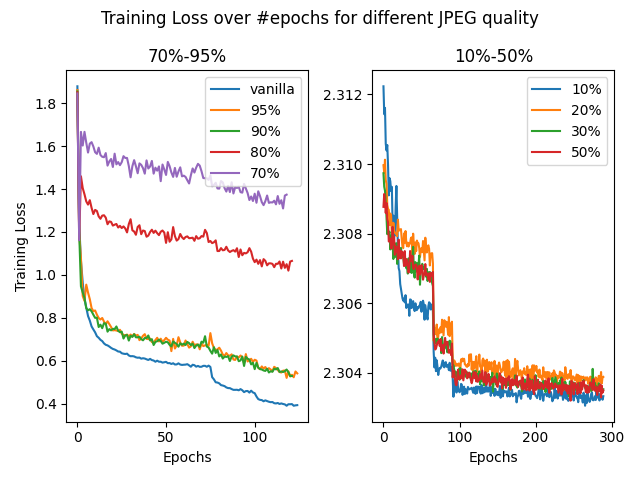

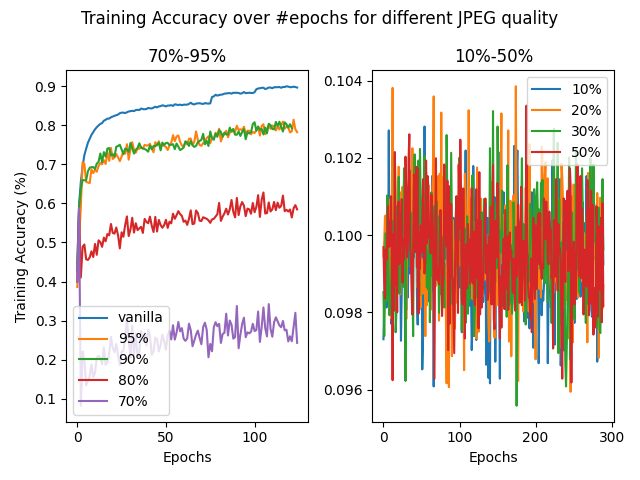

We can see from the plots that a training does occur for models trained on compressed image with a quality compression between 70% and 95%. However, the lower quality we set, the poorer is the training.

This is expectable since JPEG is a lossy compression algorithm and decreasing the quality will result in more loss of information, thus giving blurrier images where the network can have difficulties to extract the features

Let's see if the valiation lsos and accuracy follow the same logic

#### Validation loss and accuracy

Let's see the training loss and accuracy of the models

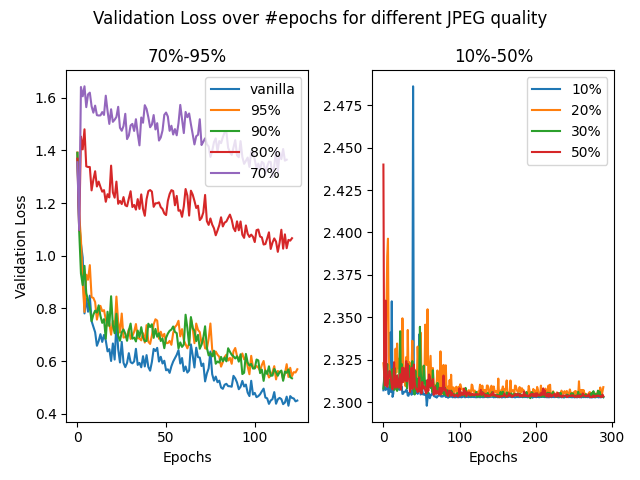

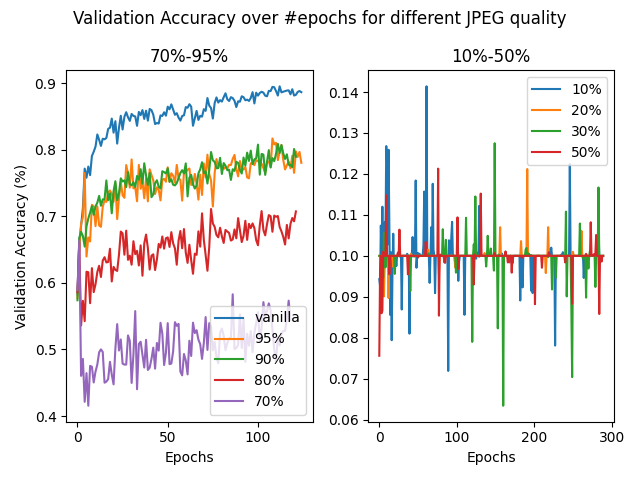

As expected, the validation loss and accuracy also shows a correlation between the compression quality and the training performance.


The training accuracies of qualities between 10% and 50% stay around 10% because of the vanishing gradient problem : The networks only output 1 label and since the dataset is balanced and has 10 classes, the accuracy is equal to 10% approximately on each epoch

#### Discussion : Vanishing gradient for qualities <50%

We can observe very poor training performance (or non-existant) for JPEG qualities below 50%. With further analysis, we can observe the vanishing gradient phenomenon where gradients are too low to update the weights. 

The outputs of each network seem to be constant over the entire training and validation set. For example, the model trained on a JPEG quality of 20% would only output the 6th class while the model trained on a JPEG quality of 50% would only output the 2nd class.

I couldn't manage to find out the reason behind this vanishing gradient effect, it would be easy to say that lower quality data could be the cause but the difference of performance between a JPEG qulaity of 50% and 70% really seem too abrupt... I suspect a more complex cause, maybe in the architecture of the network.


#### TTA to 70% validation accuracy

As seen in the lectures, TTA is a good metric if we want to observe the model's performance. We choose a threshold of 70% validation accuracy and record the time the training took to achieve that score

Since only the models trained on qualities between 70% and 95% managed to reach that threshold, we will only plot them and assume the other models just never reach the threshold.

Please note that the runs for this plot and the runs for the previous validation accuracies plot are different

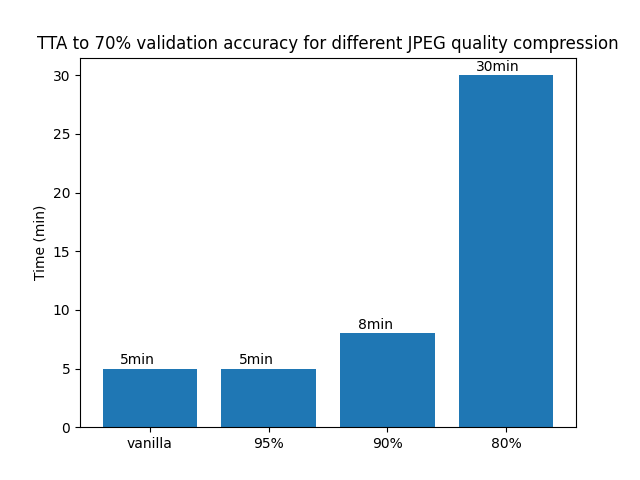

### Hardware utilization

It can be interesting to see the effect of the dataset compression on the hardware utilization.

Since Computer Vision tasks mainly rely on GPU and memory utilization, we will focus on these 2 resources.

First, we'll be interested in the moving average of the hardware utilization since plotting epoch by epoch would give very noisy and unreadable plots. See the example below where the transparent curve is the epoch by epoch measurement and the bold line is the moving average between 50 consecutive epochs (which is why it ends at epoch = 250 insteand of epoch = 300)

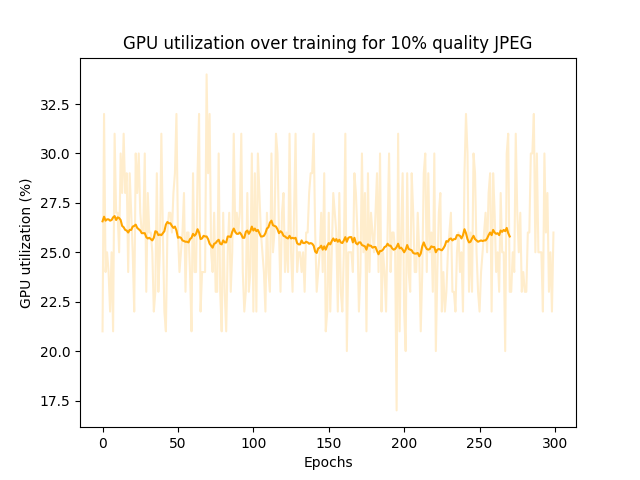

#### GPU Utilization

The moving average of the GPU utilization is shown below in a plot and a bar chart

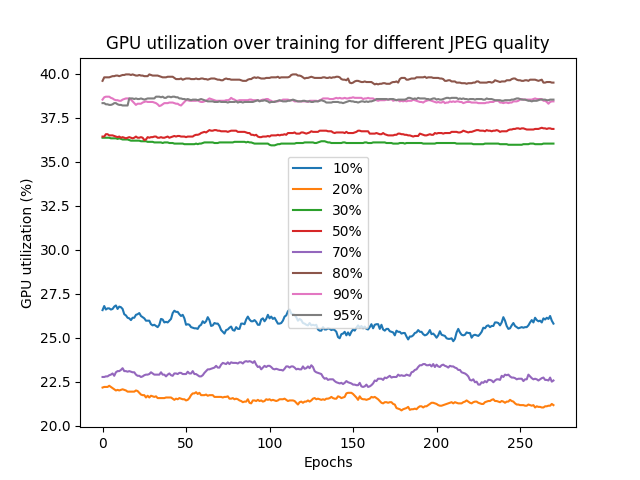

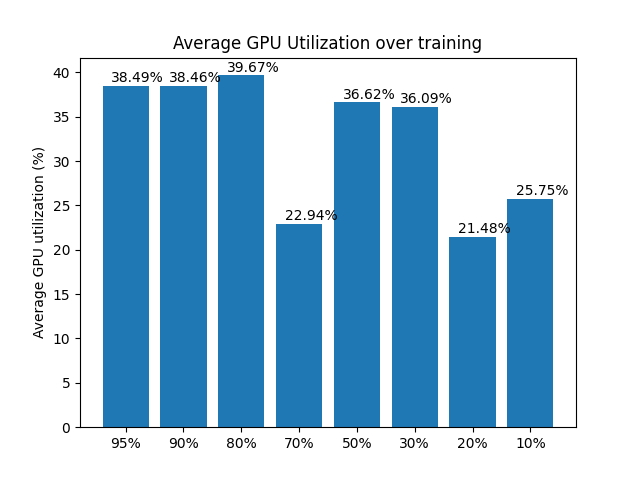

#### Memory Utilization

The moving average of the Memory utilization is shown below in a plot and a bar chart

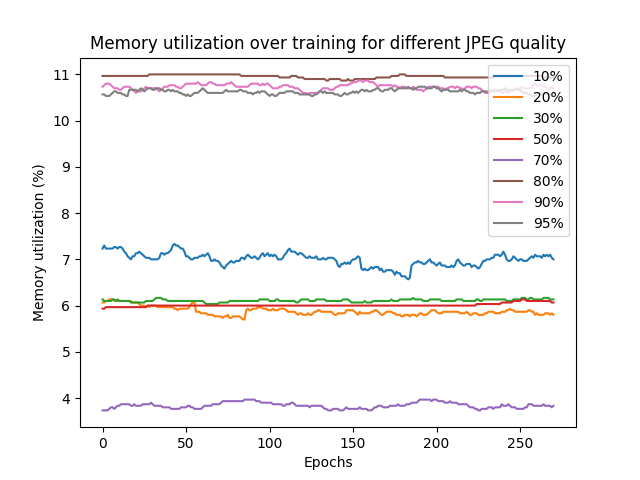

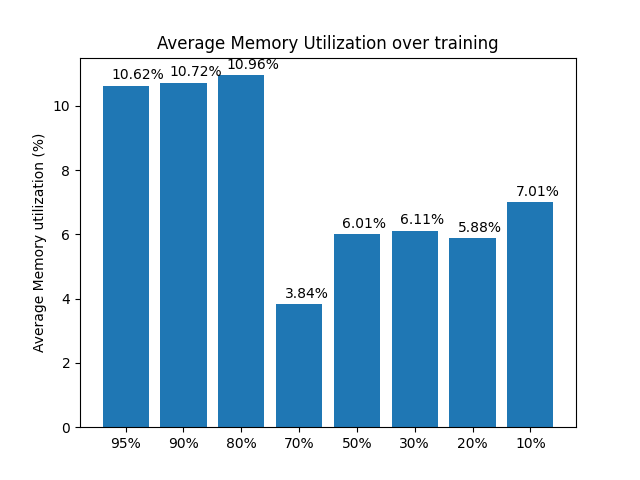

#### Discussion 

We can observe a difference in the GPU utilization which may not mean anything. Maybe the Greene cluster was differently busy at the time of the training. I don't see what we can say about it. We could expect that the GPU utilization doesn't depend on the image compression since the number of images and the batch size remain the same during the training.


However, we can observe a visible difference in the Memory utilization. Qualities between 80% and 95% seem to eat more memory during training than qualities below 70%.
This shows that more memory become available once we compress the data, meaning that the system performance can be boosted with a better job scheduling or resource allocation.

# Discussion

We've seen in the previous experiment that a lossy compression algorithm such as JPEG result in different system performances. We could expect such effect since a lossy compression algorithm would lose some information that may have been useful for the network. 

Let's sum up the important observation : 



*   Stronger compression with lower quality result in lower training performance. A 95% quality result in the same TTA but a smaller dataset size, meaning that we can add more images to the dataset and hopefully get even better results with the same memory allocation for the dataset. However, it seems that qualities below 50% result in a vanishing gradient problem where the models don't train anymore but it hard to figure if it is truly because of the compression or a more complex problem that happened during the training ?

*   Stronger compression with lower quality don't seem to impact the GPU utilization but do seem to achieve a lower memory utilization. This gives more freedome to cloud services in their scheduling algorithm or memory allocation, thus improving the overall system 



Let's now focus on lossless compression algorithm and see their effect on the system performance

# Second experiment : WebM lossless Compression

In this experiment, we will compress the CIFAR-10 dataset using the JPEG algorithm with different qualities and compare the evolution of different metrics such as : TTA (75% validation accuracy), GPU utilization, memory utilization, total dataset size in Mb

Let's see if this "loss" can be useless to the human eye but harmful to the network training

## Compress data

Let's compress the training data 1,2, ..., N times using the WebM compression method with N different compress_level. It is important to not compress the test data as it should be a benchmark for every runs

Compress Levels are between 1 (little compression) and 100 (optimized compression). Doc here : https://pillow.readthedocs.io/en/stable/handbook/image-file-formats.html#webp

In [15]:
def compress_WebP(x_train, quality) :
    N_DATA = len(x_train)
    print('Compressing ...')
    output = io.BytesIO() # Create BytesIO object
    # Load all training images and write into BytesIO object
    for numpy_img in x_train:
        im = Image.fromarray(numpy_img)
        im.save(output, format='WebP', lossless= False, quality= quality)
    print('Done compressing')

    nbytes_dataset = output.getbuffer().nbytes # Size of compressed dataset in bytes

    # Read back images from BytesIO ito list
    print('Reading image from buffer...')
    compressed_dataset = [np.array(Image.open(output)) for _ in range(N_DATA)]
    print('Done reading')
    
    return np.array(compressed_dataset), nbytes_dataset

In [16]:
QUALITIES = [1, 10, 20, 30, 50, 70, 80, 90, 100] # WebP quality parameters

nbytes_datasets = [] # byte size of dataset after each compression compression
compressed_datasets = [] # the N training datasets

x_train_ = x_train.astype('uint8')
for i, comp_lvl in enumerate(QUALITIES) :
  print(f'Iteration n°{i+1}')
  compr_dts, nbytes_dts = compress_WebP(x_train_, comp_lvl)
  compressed_datasets.append(compr_dts.astype('float32'))
  nbytes_datasets.append(nbytes_dts)

Iteration n°1
Compressing ...
Done compressing
Reading image from buffer...
Done reading
Iteration n°2
Compressing ...
Done compressing
Reading image from buffer...
Done reading
Iteration n°3
Compressing ...
Done compressing
Reading image from buffer...
Done reading
Iteration n°4
Compressing ...
Done compressing
Reading image from buffer...
Done reading
Iteration n°5
Compressing ...
Done compressing
Reading image from buffer...
Done reading
Iteration n°6
Compressing ...
Done compressing
Reading image from buffer...
Done reading
Iteration n°7
Compressing ...
Done compressing
Reading image from buffer...
Done reading
Iteration n°8
Compressing ...
Done compressing
Reading image from buffer...
Done reading
Iteration n°9
Compressing ...
Done compressing
Reading image from buffer...
Done reading


Let's plot the dataset size decrease thanks to the compressions

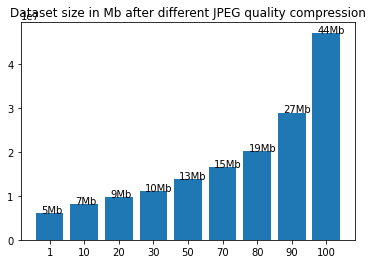

In [17]:
plt.figure()
plt.bar([str(q) for q in QUALITIES], nbytes_datasets)
plt.title('Dataset size in Mb after different JPEG quality compression')
xlocs, _ = plt.xticks()
for i, v in enumerate(nbytes_datasets):
    plt.text(xlocs[i] - 0.25, v + 0.01, str(v//2**20) + 'Mb')

We can notice a significant improvement on the dataset size but I really doubt that the quality compression of 1% would result in only 5Mb of dataset... There must be an error somewhere but the code seems coherent ?

Let's compare the original dataset and the compressed ones 

Label = frog


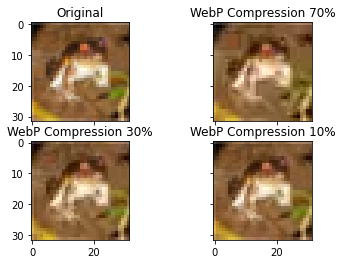

In [21]:
print(f"Label = {classes[np.argmax(y_train[0])]}")
fig, axs = plt.subplots(2,2)
axs[0, 0].imshow(x_train.astype('uint8')[0])
axs[0, 0].set_title('Original')

axs[0, 1].imshow(compressed_datasets[3].astype('uint8')[0])
axs[0, 1].set_title('WebP Compression 70%')

axs[1, 0].imshow(compressed_datasets[5].astype('uint8')[0])
axs[1, 0].set_title('WebP Compression 30%')

axs[1, 1].imshow(compressed_datasets[-1].astype('uint8')[0])
axs[1, 1].set_title('WebP Compression 10%')

for ax in axs.flat:
    ax.label_outer()

If we focus on pixels we can notice differences between the compressions but as expected, lossless compression do not change a lot the image quality as they do not lose any "information" during the compression

## Training

Now we train on each compressed dataset (on Greene)

In [19]:
for i, train_set in enumerate(compressed_datasets) :
  model = create_model()
  #training
  opt_rms = keras.optimizers.RMSprop(learning_rate=0.001,decay=1e-6)
  model.compile(loss='categorical_crossentropy', optimizer=opt_rms, metrics=['accuracy'])
  history = model.fit(datagen.flow(train_set, y_train, batch_size=batch_size),\
                      steps_per_epoch=train_set.shape[0] // batch_size,epochs= EPOCHS,\
                      verbose=1,validation_data=(x_test,y_test),callbacks=[LearningRateScheduler(lr_schedule), MonitorCallback(val_acc_threshold)])

  #save to disk
  model_json = model.to_json()
  with open(f'model_{i}.json', 'w') as json_file:
      json_file.write(model_json)

  model.save_weights(f'model_{i}.h5')  

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 activation (Activation)     (None, 32, 32, 32)        0         
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 32, 32, 32)        0         
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                        

TypeError: ignored

## System Performance

The models were fully trained on Greene and plots were saved to be displayed here

### Model Performance

We'll see 2 important observation :


*   For a quality % between 20% and 100%, it seems like the model performances decrease from the original but doesn't change
*   For a quality % below 10%, we'll see poor and non-existant performance of the models as they couldn't even train (vanishing gradient problem) just like before with the JPEG compressions with quality < 50%

Therefore, we'll separate the 2 cases (>20% and <10%) to make sure the plots are readable



#### Training loss and accuracy


Let's see the training loss and accuracy of the models

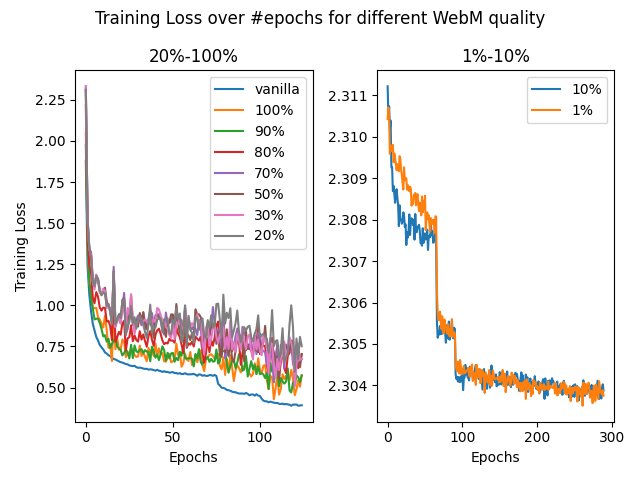

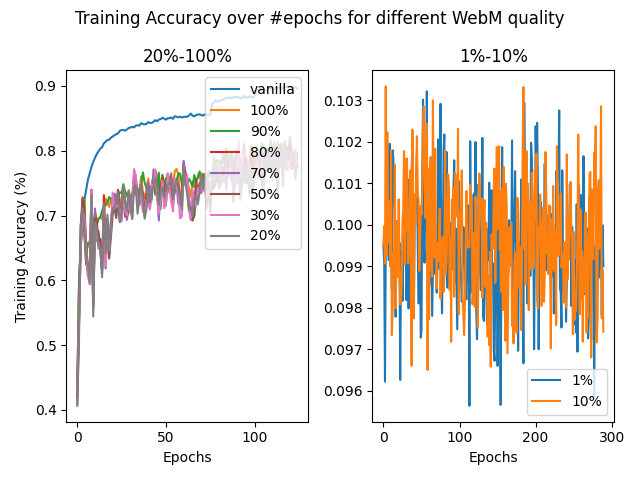

We can see from the plots that a training does occur for models trained on compressed image with a quality compression between 20% and 100%. However, the training is a bit poorer than the vanilla (see TTA later). Notice how the performance doesn't decrease even with qualities between 20% and 100%

The training accuracies of qualities 1% and 10% stagnate around 10% because of the vanishing gradient problem : The networks only output 1 label and since the dataset is balanced and has 10 classes, the accuracy is equal to 10% approximately on each epoch

This is expectable since WebM is a lossless compression algorithm and decreasing the quality will result in no loss of information, thus giving the same "information" to the network than with the vanilla dataset

Let's see if the valiation loss and accuracy follow the same logic

#### Validation loss and accuracy

Let's see the training loss and accuracy of the models

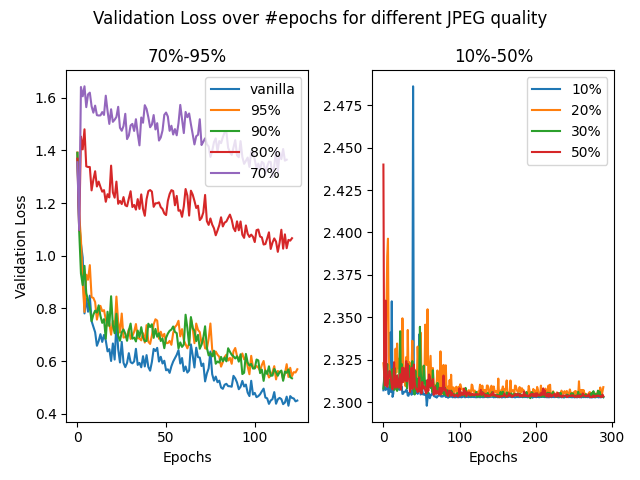

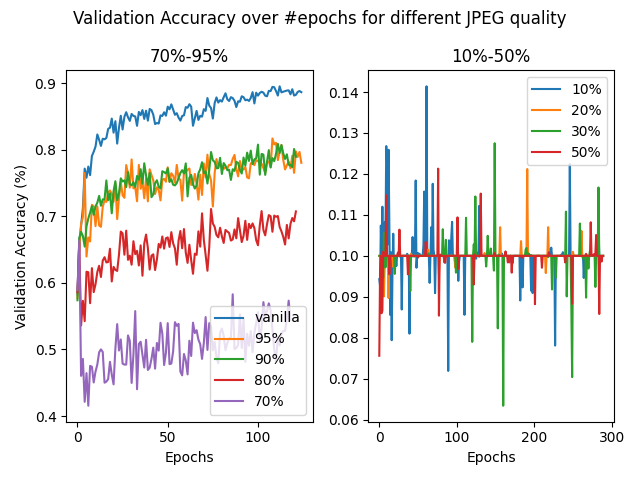

As expected, the validation loss and accuracy also shows a correlation between the compression quality and the training performance.

#### Discussion : Vanishing gradient for qualities <50%

We can observe very poor training performance (or non-existant) for WebM qualities below 10%. With further analysis, we can observe the same vanishing gradient phenomenon than the previous experiment with the JPEG compression

2 different interpretation :



*   Either the compression algorithms really do cause the vanishing gradient, which I doubt since it really seems to come "out of nowhere".
*   Either the effect is due to more complex causes which I ignore as I explaned in the previous discussion related to this topic in the JPEG experiment




#### TTA to 70% validation accuracy

We choose a threshold of 70% validation accuracy jsut like before and record the time the training took to achieve that score

Since only the models trained on qualities between 20% and 100% managed to reach that threshold, we will only plot them and assume the other models just never reach the threshold.

Please note that the runs for this plot and the runs for the previous validation accuracies plot are different

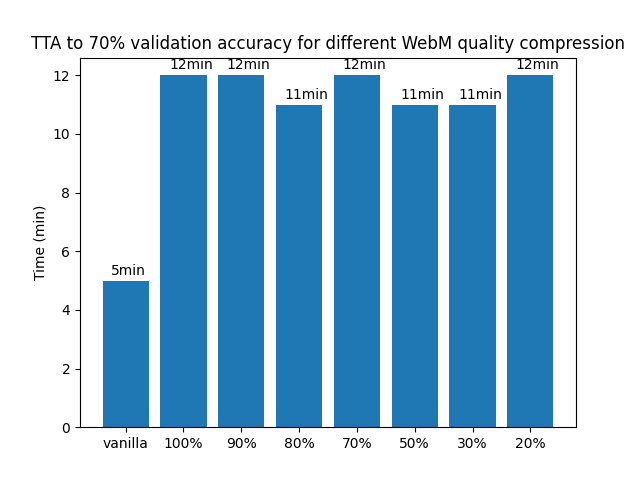

We can better observe how the compression did make the training performance worse but not above a certain threshold. For compression qualities between 20% and 100% it seems like the TTA to 70% stay around 12 minutes.

### Hardware utilization

#### GPU Utilization

The moving average of the GPU utilization is shown below in a plot and a bar chart

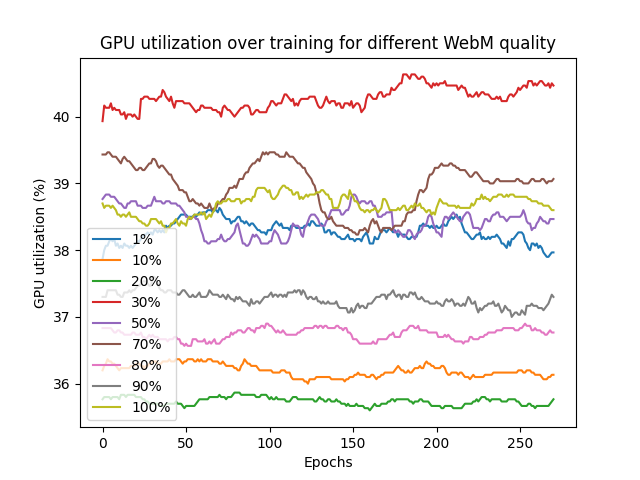

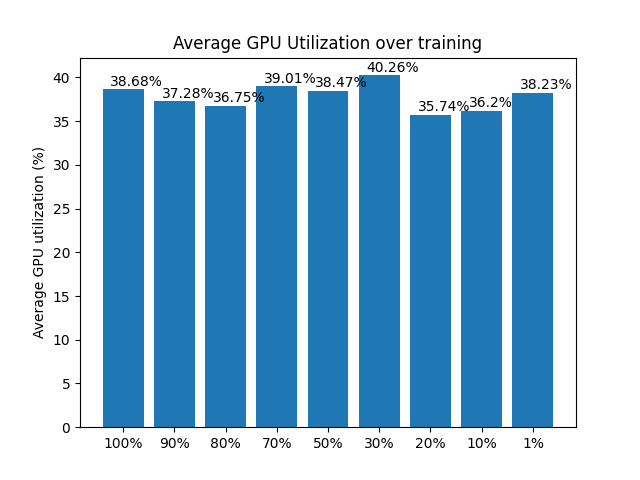

#### Memory Utilization

The moving average of the Memory utilization is shown below in a plot and a bar chart

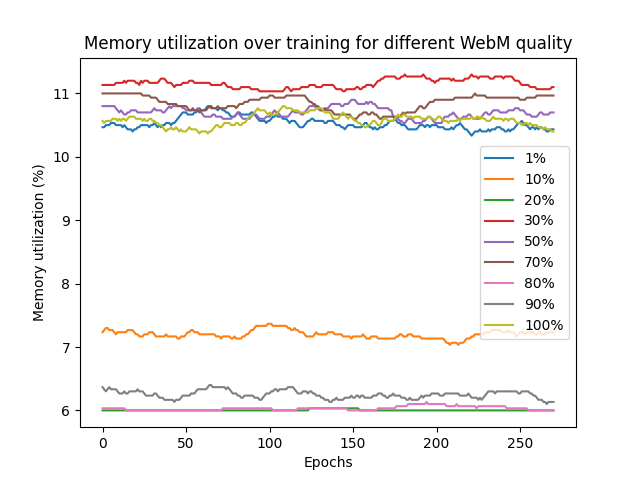

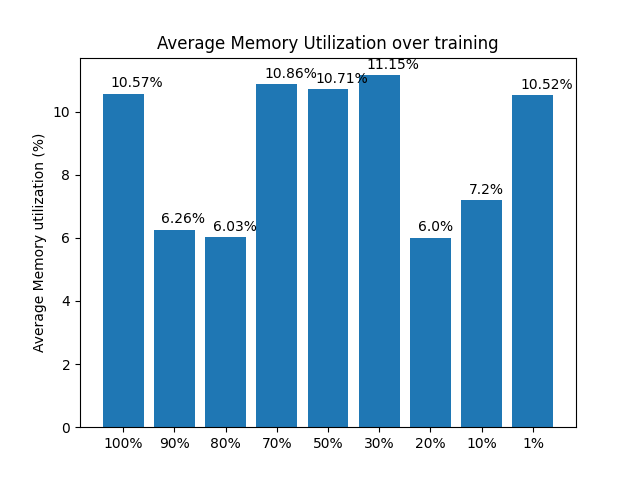

#### Discussion 

We can observe no difference in the GPU utilization. We could expect that the GPU utilization doesn't depend on the image compression since the number of images and the batch size remain the same during the training.


However, we can observe some difference in the Memory utilization. Qualities between 80% and 90%  and between 10% and 20% seem to eat less memory during training than other qualities.

The reason why is unknown and may be a simple effect of different scheduling process in the Greene cluster at that time. These graphs don't show any valuable effect of the lossless WebM compression on the hardware utilization